# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
import myOptimizers as optims
import os
import importlib

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
PRC1 = 20 # Probability regularisation co-efficient for degree 1 (and -1)
PRC2 = PRC1/(2*2) # Probability regularisation co-efficient for degree 2 (and -2)
PRC3 = PRC2/(2*3) # Probability regularisation co-efficient for degree 3 (and -3)
PRC4 = PRC3/(2*4) # Probability regularisation co-efficient for degree 4 (and -4)

def floatStr (Efloat) :
    Eint = int(np.floor(Efloat))
    if Efloat - Eint == 0 :
        return str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    return np.mean(diffeq**2) + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4)


trunc = -1
iterList = []
diffeqList = []
diffeqDiffList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    

    loss = mean + (1-prob)**2 + (PRC1/prob + PRC1*prob) + \
        (PRC2/prob**2 + PRC2*prob**2) + (PRC3/prob**3 + PRC3*prob**3) + \
        (PRC4/prob**4 + PRC4*prob**4)
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))

    print ("Iteration " + str(step) + "\ndiffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))

# Callback function.
def callback(params, step, g):
    global trunc
    global diffeqList
    
    if step % 100 == 0:
        objectiveDebug (params, step)
        
        if step > 100 :
            if trunc == -1 and np.abs(diffeqDiffList[-1]) < 10**-2 and diffeqDiffList[-1] < 0 :
                trunc = int(step/100)
                print ("Set at index = " + str(trunc))        

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 4 # Length of the well
n = 3 # Energy level to be found
scale = 2*L # Scale for initialisation
divs = 200 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 1])

# Intialise a guess eigenvalue to find a true eigenvalue near it
initE = 3.25
params = {'nn': nnparams, 'E': initE}

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

# Optimization

In [6]:
optims = importlib.reload (optims)
params = optims.myAdam (grad(objective), params, callback=callback, step_size=0.001, diffeqList=diffeqList, probList=probList, diffeqDiffList = diffeqDiffList)

Iteration 100
diffeq = 4.89945486018896 prob = 0.9978002508491696
loss = 56.774698136273564 E = 3.219973924340957
---------------------------------
Iteration 200
diffeq = 2.460469653484478 prob = 0.982016813324784
loss = 54.35198578676441 E = 3.1820823063528563
diffeqDiff = -2.4389852067044817
---------------------------------
Iteration 300
diffeq = 1.8054148022013021 prob = 0.9855225148534712
loss = 53.691081545763254 E = 3.129076274382311
diffeqDiff = -0.6550548512831758
---------------------------------
Iteration 400
diffeq = 1.4108691027071398 prob = 0.9926372659343976
loss = 53.28860843595117 E = 3.059438407958691
diffeqDiff = -0.3945456994941623
---------------------------------
Iteration 500
diffeq = 1.1518171304838583 prob = 0.9926755031485202
loss = 53.02952798227922 E = 2.97823012640272
diffeqDiff = -0.2590519722232816
---------------------------------
Iteration 600
diffeq = 0.9225282046675674 prob = 0.9937301050874383
loss = 52.79951254965523 E = 2.8923741053448886
diffeqDif

Iteration 4400
diffeq = 0.005734826039080361 prob = 1.0002686276612436
loss = 51.880738445154165 E = 1.2502994524400142
diffeqDiff = -0.001689562964654532
brkCount2 = 25
---------------------------------
Iteration 4500
diffeq = 0.004644719266642191 prob = 1.0000092447891848
loss = 51.87964472355416 E = 1.2439474946594684
diffeqDiff = -0.0010901067724381694
brkCount2 = 26
---------------------------------
Iteration 4600
diffeq = 0.003914397170423265 prob = 1.000336389858121
loss = 51.87892007206618 E = 1.2397822276006372
diffeqDiff = -0.0007303220962189263
Reached 10**-3 at 4600
brk4Lim = 9200
brkCount3 = 1
---------------------------------
Iteration 4700
diffeq = 0.0034197289728428943 prob = 0.9997552143383703
loss = 51.878422735681895 E = 1.2371812175006216
diffeqDiff = -0.0004946681975803707
brkCount3 = 2
---------------------------------
Iteration 4800
diffeq = 0.0030178796641914542 prob = 1.000799273865387
loss = 51.87804990299303 E = 1.235630253577329
diffeqDiff = -0.0004018493086

Iteration 8500
diffeq = 0.0004444008323087716 prob = 1.0005550842665747
loss = 51.8754598497093 E = 1.2336963192856336
diffeqDiff = -4.805309593480605e-06
brkCount4 = 19
---------------------------------
Iteration 8600
diffeq = 0.00045144538104232993 prob = 0.9999941430777357
loss = 51.875451447101945 E = 1.2337077893755581
diffeqDiff = 7.044548733558316e-06
---------------------------------
Iteration 8700
diffeq = 0.00042151138128017904 prob = 0.9990160633032228
loss = 51.87547012620034 E = 1.2337076225400756
diffeqDiff = -2.9933999762150887e-05
brkCount4 = 20
---------------------------------
Iteration 8800
diffeq = 0.00040233619963313656 prob = 1.0001727761699963
loss = 51.87540383350162 E = 1.2337024748865348
diffeqDiff = -1.917518164704248e-05
brkCount4 = 21
---------------------------------
Iteration 8900
diffeq = 0.0031881637588789197 prob = 0.9995143175904366
loss = 51.87820000307985 E = 1.2337236255279658
diffeqDiff = 0.002785827559245783
---------------------------------
Iter

# Plots

In [7]:
replot = 1
if replot == 1 :
    params['E'] = initE
    n = 2
    L = 4
    name = "n" + str(n)+ "L" + floatStr(L) + "E" + floatStr(float(params['E']))

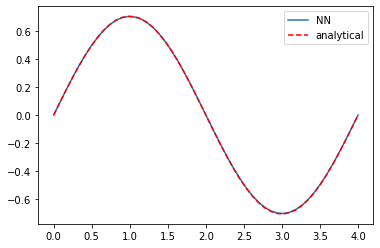

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

In [ ]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (2 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagAll.png")

In [ ]:
if trunc != -1 :
    fig = plt.figure (figsize=(10,10))

    plt.subplot (2 , 2 , 1)
    plt.plot (iterList[trunc:], diffeqList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeq')

    plt.subplot (2, 2, 2)
    plt.plot (iterList[trunc:], probList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('prob')

    plt.subplot (2, 2, 3)
    plt.plot (iterList[trunc:], lossList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('loss')

    plt.subplot (2, 2, 4)
    plt.plot (iterList[trunc:], EList[trunc:])
    plt.ylabel ('Eigenenergy')
    plt.xlabel ('iterations')
    plt.tight_layout()

    plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

In [ ]:
fig = plt.figure (figsize=(5,5))
plt.clf ()

if trunc != -1 :
    plt.subplot (2 , 1 , 1)
    plt.plot (iterList, diffeqDiffList)
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

    plt.subplot (2 , 1 , 2)
    plt.plot (iterList[trunc:], diffeqDiffList[trunc:])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')
else :
    plt.plot (iterList, diffeqDiffList)
    #plt.yticks ([min(diffeqDiffList), -10**-4, 10**-4, max(diffeqDiffList)])
    plt.xlabel ('iterations')
    plt.ylabel ('diffeqDiff')

plt.tight_layout()
plt.savefig (name + "_diffeqDiff.png")

# Write to file

In [ ]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + \
"\nprob = " + str(round(probList[-1],8)) + \
"\nloss = " + str(round(lossList[-1],8)) + \
"\neigE = " + str(round(EList[-1],8)) + \
"\ndiffeqDiff = " + str(round(diffeqDiffList[-1],8))

    
outfile.write (fstr)
outfile.close ()